In [12]:
import librosa

In [13]:
y, sr = librosa.load('op10.wav')

In [14]:
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

In [15]:
print(tempo)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

[99.38401442]


In [22]:
print(y.shape)

(2031658,)


In [16]:
print(beat_times)

[ 1.50929705  2.15945578  2.80961451  3.4829932   4.15637188  4.80653061
  5.4799093   6.15328798  6.89632653  7.56970522  8.17342404  8.77714286
  9.38086168  9.9845805  10.56507937 11.16879819 11.74929705 12.35301587
 12.95673469 13.56045351 14.16417234 14.76789116 15.37160998 15.9753288
 16.55582766 17.15954649 17.76326531 18.36698413 18.97070295 19.57442177
 20.17814059 20.78185941 21.36235828 21.94285714 22.56979592 23.15029478
 23.73079365 24.35773243 24.96145125 25.56517007 26.14566893 26.74938776
 27.35310658 27.98004535 28.56054422 29.16426304 29.76798186 30.37170068
 30.9754195  31.55591837 32.15963719 32.76335601 33.34385488 33.97079365
 34.55129252 35.15501134 35.75873016 36.36244898 36.9661678  37.56988662
 38.15038549 38.77732426 39.38104308 40.10086168 40.82068027 41.470839
 42.07455782 42.67827664 43.25877551 43.86249433 44.46621315 45.04671202
 45.65043084 46.27736961 46.88108844 47.4615873  48.04208617 48.66902494
 49.27274376 49.87646259 50.45696145 51.03746032 51.66

In [17]:
tempogram = librosa.feature.tempogram(y=y)

In [18]:
print(tempogram.shape)

(384, 3969)


In [19]:
hop_length = 512

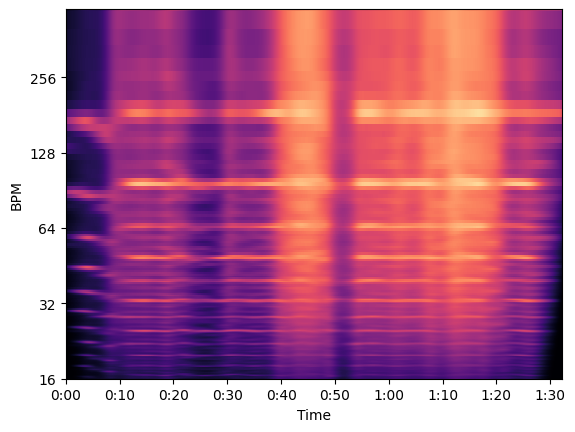

In [20]:
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='magma')

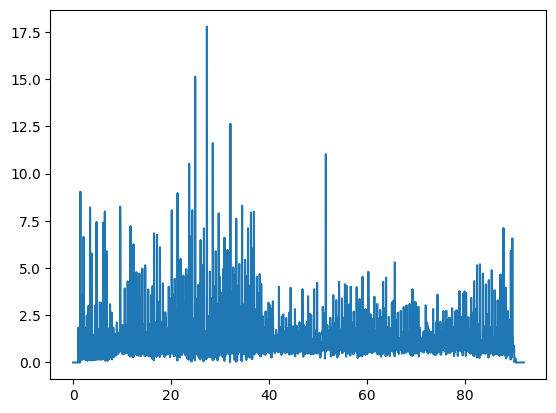

In [24]:
import matplotlib.pyplot as plt
import numpy as np

onset = librosa.onset.onset_strength(y=y)
plt.plot(librosa.times_like(onset), onset)

In [25]:
onset.shape

(3969,)

In [28]:
onsets = librosa.onset.onset_detect(y=y, onset_envelope=onset)
print(librosa.frames_to_time(onsets))

[ 1.09133787  1.4860771   1.83437642  2.13623583  2.48453515  2.80961451
  3.13469388  3.4829932   3.80807256  4.48145125  4.80653061  5.4799093
  5.82820862  6.13006803  6.5015873   6.89632653  7.56970522  7.91800454
  9.63628118 10.56507937 11.16879819 11.44743764 11.74929705 12.05115646
 12.35301587 12.95673469 13.56045351 13.86231293 14.14095238 14.7446712
 15.34839002 15.95210884 16.25396825 16.55582766 17.13632653 17.64716553
 17.76326531 17.94902494 18.36698413 18.64562358 18.85460317 18.97070295
 19.55120181 19.87628118 20.17814059 20.66575964 20.78185941 21.06049887
 21.33913832 21.64099773 21.89641723 21.94285714 22.26793651 22.54657596
 22.75555556 23.01097506 23.15029478 23.33605442 23.4521542  23.73079365
 24.03265306 24.33451247 24.65959184 24.96145125 25.44907029 25.56517007
 25.77414966 26.05278912 26.14566893 26.44752834 26.7261678  27.35310658
 27.56208617 27.9568254  28.28190476 28.56054422 28.86240363 29.16426304
 29.35002268 29.62866213 29.76798186 29.97696145 30.3

In [29]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

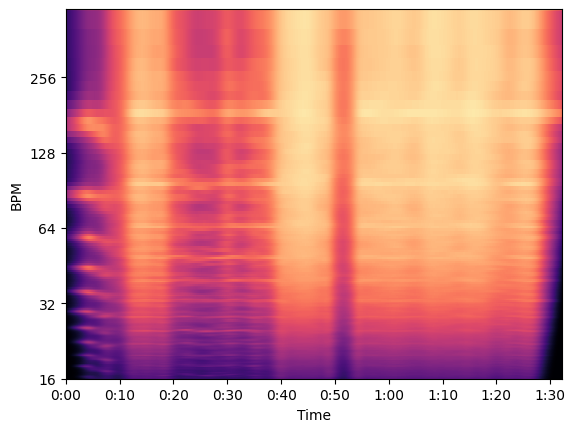

In [30]:
librosa.display.specshow(librosa.feature.tempogram(y=y_harmonic), sr=sr, hop_length=hop_length, x_axis='time', y_axis='tempo', cmap='magma')

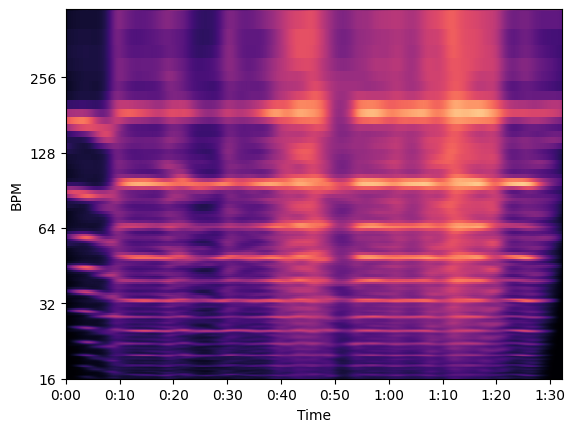

In [31]:
librosa.display.specshow(librosa.feature.tempogram(y=y_percussive), sr=sr, hop_length=hop_length, x_axis='time', y_axis='tempo', cmap='magma')

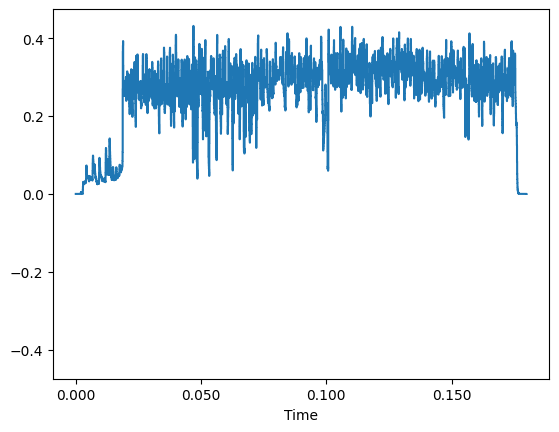

In [33]:
librosa.display.waveshow(librosa.feature.rms(y=y))

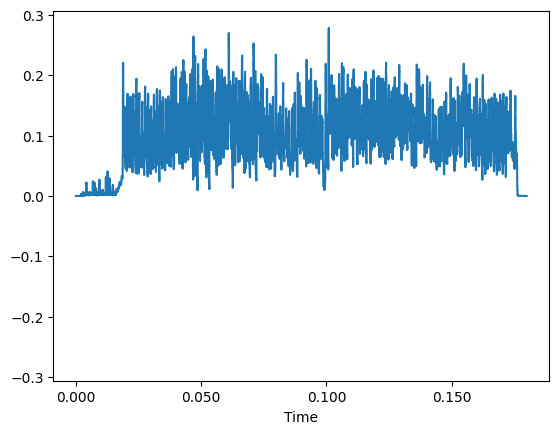

In [34]:
librosa.display.waveshow(librosa.feature.rms(y=y_percussive))   

In [40]:
rms_harmonic = librosa.feature.rms(y=y_harmonic)

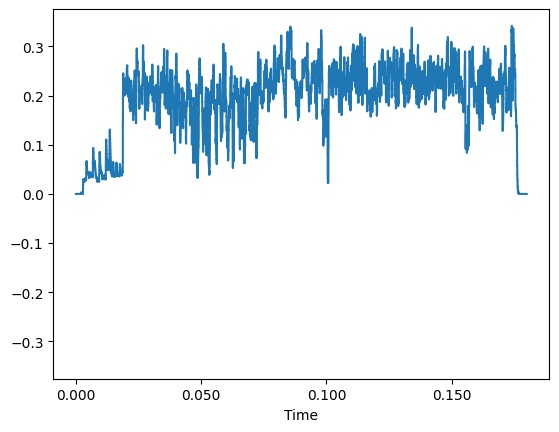

In [41]:
librosa.display.waveshow(rms_harmonic)

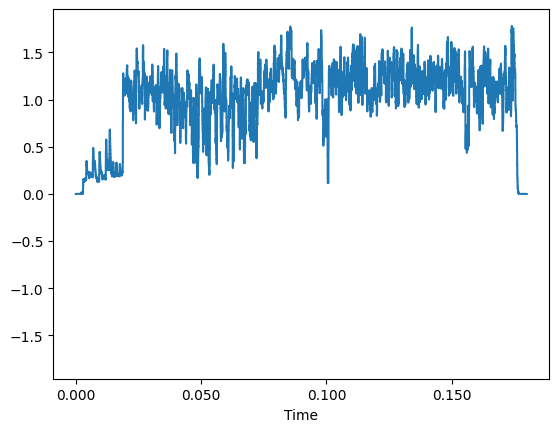

In [43]:
librosa.display.waveshow(rms_harmonic / rms_harmonic.mean())

In [32]:
import torch
from torch import Tensor, nn

In [70]:
class ResidualBlock1d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
    ):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.res_conv = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False)
    
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.relu(out + self.res_conv(identity))
        return out

In [46]:
RMS_SIZE = 3885

In [71]:
class OptimalStartModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 3885, 1
        self.rms_block1 = ResidualBlock1d(1, 4)
        # 3885, 4
        self.rms_maxpool1 = nn.MaxPool1d(3)
        # 1295, 4
        self.rms_block2 = ResidualBlock1d(4, 8)
        # 1295, 8
        self.rms_maxpool2 = nn.MaxPool1d(3)
        # 432, 8
        self.rms_block3 = ResidualBlock1d(8, 16)
        # 432, 16
        self.rms_maxpool3 = nn.MaxPool1d(4)
        # 108, 16
        self.rms_block4 = ResidualBlock1d(16, 32)
        # 108, 32
        self.rms_maxpool4 = nn.MaxPool1d(4)
        # 17, 32
        self.rms_flatten = nn.Flatten()
        self.rms_dropout = nn.Dropout(p=0.2)
        self.rms_linear = nn.Linear(17 * 32, 2)
        self.rms_net = nn.Sequential(
            self.rms_block1,
            self.rms_maxpool1,
            self.rms_block2,
            self.rms_maxpool2,
            self.rms_block3,
            self.rms_maxpool3,
            self.rms_block4,
            self.rms_maxpool4,
            self.rms_flatten,
            self.rms_dropout,
            self.rms_linear,
        )
    
    def forward(self, x: Tensor) -> Tensor:
        return self.rms_net(x)

In [72]:
model = OptimalStartModel()
sum([p.numel() for p in model.parameters()])

8114

In [53]:
class AOQItem:
    def __init__(
        self, 
        filename: str, 
        start: float = None,
        end: float = None,
        train: bool = False,
        ans_start: float = None, 
        ans_end: float = None, 
        mode: str = 'cut',
    ):
        self.start = start
        self.end = end
        self.train = train
        self.ans_start = ans_start
        self.ans_end = ans_end
        
        self.y, self.sr = librosa.load(filename, sr=22100)
        total_samples = RMS_SIZE * hop_length
        if mode == 'cut':
            sample_start = (0 if self.start is None else self.start) * self.sr
            sample_end = sample_start + total_samples
            self.y = self.y[sample_start:sample_end]
            self.y.resize(RMS_SIZE * hop_length)
        elif mode == 'resample':
            raise NotImplementedError('"resample" mode has not been implemented yet')
        self.y_harmonic = librosa.effects.harmonic(self.y)
        self.rms_harmonic = librosa.feature.rms(y=y_harmonic, hop_length=hop_length)
    
    def rms_as_input(self):
        return self.rms_harmonic / self.rms_harmonic.mean()
    
    def as_train(self):
        if not self.train:
            raise RuntimeError('as_train() allowed only in train mode')
        return self.rms_as_input(), librosa.time_to_frames([self.ans_start, self.ans_end], hop_length=hop_length, sr=self.sr)

In [58]:
x = AOQItem('op10.wav')

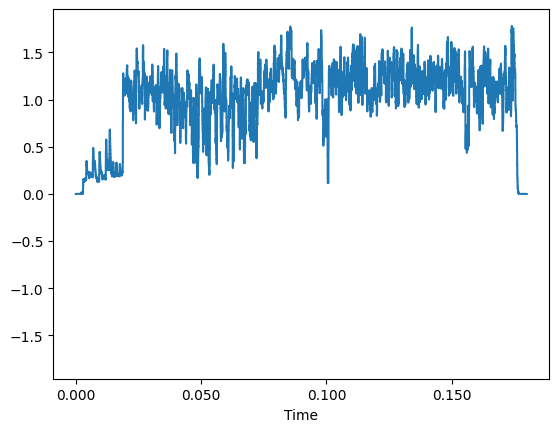

In [59]:
librosa.display.waveshow(x.rms_as_input())